# Beer - Choosing the right one for you!

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn

from src.beer_utils import *

In [2]:
BEER_DATA_PATH = 'data/beer_reviews.csv'

In [3]:
raw_beer_data = pd.read_csv(BEER_DATA_PATH)

In [12]:
raw_beer_data.head(5)

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


# Can we use all the data?

In [5]:
raw_beer_data.isna().sum()

brewery_id                0
brewery_name             15
review_time               0
review_overall            0
review_aroma              0
review_appearance         0
review_profilename      348
beer_style                0
review_palate             0
review_taste              0
beer_name                 0
beer_abv              67785
beer_beerid               0
dtype: int64

There are 15 datapoints without brewery name. IGNORE NOW, nice to have

# Is getting drunk your ultimate goal?

#### Then we can select your new favorite brewery solely on that parameter

In [6]:
brewery_average_abv, max_average_abv, max_average_abv_name = highest_abv_by_group(df=raw_beer_data, group_type='brewery_name')

<AxesSubplot:xlabel='brewery_name'>

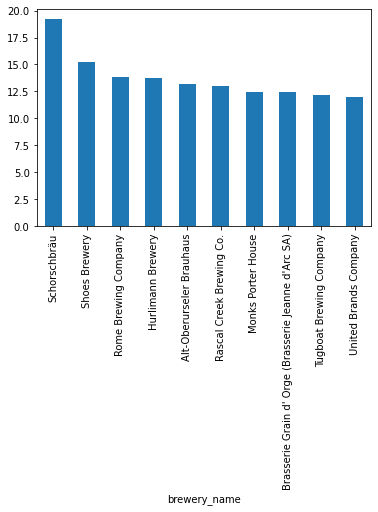

In [7]:
brewery_average_abv.nlargest(10).plot(kind='bar')

#### Or maybe we can find your new favorite beer type based on abv?

In [8]:
beer_type_average_abv, max_average_beer_type_abv, max_average_beer_type_abv_name = highest_abv_by_group(df=raw_beer_data, group_type='beer_style')

<AxesSubplot:xlabel='beer_style'>

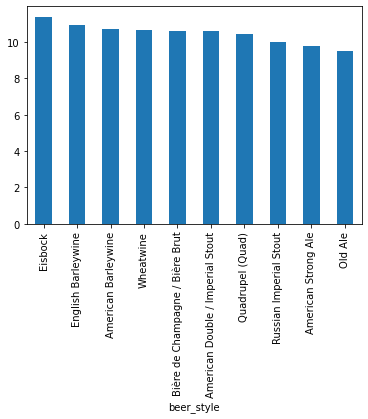

In [9]:
beer_type_average_abv.nlargest(10).plot(kind='bar')

# But... What if we also care about other aspects of the beer?

#### If we actually want a pleasant experience, we might need to look at other factors that makes a beer great

In [15]:
raw_beer_data[['review_overall','review_aroma', 'review_appearance', 'review_palate', 'review_taste']].head(5)

,review_overall,review_aroma,review_appearance,review_palate,review_taste
0,1.5,2.0,2.5,1.5,1.5
1,3.0,2.5,3.0,3.0,3.0
2,3.0,2.5,3.0,3.0,3.0
3,3.0,3.0,3.5,2.5,3.0
4,4.0,4.5,4.0,4.0,4.5


# How many reviews are enough for us to feel comfortible with the accuracy of the reviews?

According to Amazon, there should be atleast 25 reviews on a product before we trust it: https://www.searchenginejournal.com/amazon-product-reviews-best-practices/388179/#close

This might be a bit different in the beer world as the people reviewing might be more serious, so lets cut the threshold to atleast 10 reviews for now

In [10]:
# ----- Remove beers that have less than 25 reviews -----
filtered_beer_data = raw_beer_data[raw_beer_data.groupby('beer_beerid').beer_beerid.transform('count') >= 10]

print(f"Removed: {raw_beer_data.shape[0] - filtered_beer_data.shape[0]} reviews")
print(f"Remaining reviews: {filtered_beer_data.shape[0]}")

Removed: 129994 reviews
Remaining reviews: 1456620


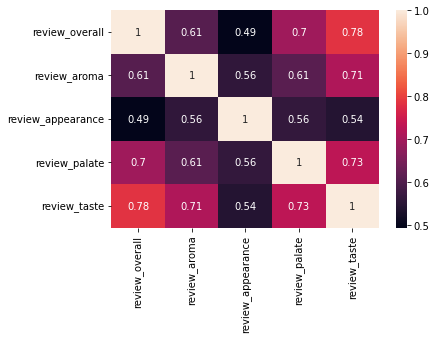

In [18]:
corr_matrix = filtered_beer_data[['review_overall','review_aroma', 'review_appearance', 'review_palate', 'review_taste']].corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()